make the forest ruth integrator work at the python level before implementing it into fotran

In [1]:
import tstrippy
import numpy as np 
from astropy import units as u
import bar_sensitivity_integration_timestep_and_time as bsitt
import matplotlib.pyplot as plt

In [2]:
# make the font size bigger and also us Latex font
plt.rc('text', usetex=True)
plt.rc('font', size=12)
plt.rc('axes', titlesize=15)
plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('legend', fontsize=12)
plt.rc('figure', titlesize=15)

load the GCs and the galaxy

In [3]:
targetGC="NGC5139"
MWparams, MWrefframe = bsitt.loadGalaxy()
x0,y0,z0,vx0,vy0,vz0=bsitt.pick_globular_cluster(targetGC,MWrefframe)
unitT, unitV, unitD, unitM, unitG, G = bsitt.loadunits()

pick the main time step

In [4]:
timestep = 1e5*u.yr
dt = timestep.to(unitT).value

In [5]:
# Define parameters for the integration
x = np.sqrt(2**(1/3) + 2**(-1/3)-1)/6
c1 = x + 1/2
c2 = -x
c3 = -x 
c4 = x + 1/2

d1 = 2*x+1
d2 = -4*x-1
d3 = 2*x+1
d4 = 0

def symplectic_step(x,y,z,vx,vy,vz,dt):

    # drift
    x += c1*dt*vx
    y += c1*dt*vy
    z += c1*dt*vz
    # kick
    ax,ay,az,_=tstrippy.potentials.pouliasis2017pii(MWparams, x, y, z)
    vx += d1*dt*ax
    vy += d1*dt*ay
    vz += d1*dt*az

    # drift
    x += c2*dt*vx
    y += c2*dt*vy
    z += c2*dt*vz
    # kick
    ax,ay,az,_=tstrippy.potentials.pouliasis2017pii(MWparams, x, y, z)
    vx += d2*dt*ax
    vy += d2*dt*ay
    vz += d2*dt*az

    # drift
    x += c3*dt*vx
    y += c3*dt*vy
    z += c3*dt*vz
    # kick
    ax,ay,az,_=tstrippy.potentials.pouliasis2017pii(MWparams, x, y, z)
    vx += d3*dt*ax
    vy += d3*dt*ay
    vz += d3*dt*az
    # drift
    x += c4*dt*vx
    y += c4*dt*vy
    z += c4*dt*vz
    # kick
    ax,ay,az,_=tstrippy.potentials.pouliasis2017pii(MWparams, x, y, z)
    vx += d4*dt*ax
    vy += d4*dt*ay
    vz += d4*dt*az
    return x,y,z,vx,vy,vz


In [6]:
tstrippy.integrator.printruthcoefficients()

 c1 =   0.67107678392066572     
 c2 =  -0.17107678392066569     
 c3 =  -0.17107678392066569     
 c4 =   0.67107678392066572     
 d1 =    1.3421535678413314     
 d2 =   -1.6843071356826629     
 d3 =    1.3421535678413314     
 d4 =    0.0000000000000000     
 c1+c2+c3+c4 =    1.0000000000000000     
 d1+d2+d3+d4 =    1.0000000000000000     
 w =   0.17107678392066569     


In [7]:
0.17107678392066569 -x 

0.0

In [8]:
NSTEPS = 100000
xt,yt,zt=np.zeros(NSTEPS+1),np.zeros(NSTEPS+1),np.zeros(NSTEPS+1)
vxt,vyt,vzt=np.zeros(NSTEPS+1),np.zeros(NSTEPS+1),np.zeros(NSTEPS+1)
xt[0],yt[0],zt[0]=x0,y0,z0
vxt[0],vyt[0],vzt[0]=vx0,vy0,vz0

for i in range(NSTEPS):
    xt[i+1],yt[i+1],zt[i+1],vxt[i+1],vyt[i+1],vzt[i+1]=symplectic_step(xt[i],yt[i],zt[i],vxt[i],vyt[i],vzt[i],dt)
time = np.arange(0, NSTEPS+1)*dt

In [9]:
# now do the reverse
xtR,ytR,ztR=np.zeros(NSTEPS+1),np.zeros(NSTEPS+1),np.zeros(NSTEPS+1)
vxtR,vytR,vztR=np.zeros(NSTEPS+1),np.zeros(NSTEPS+1),np.zeros(NSTEPS+1)
xtR[0],ytR[0],ztR[0]=xt[-1],yt[-1],zt[-1]
vxtR[0],vytR[0],vztR[0]=-vxt[-1],-vyt[-1],-vzt[-1]
for i in range(NSTEPS):
    xtR[i+1],ytR[i+1],ztR[i+1],vxtR[i+1],vytR[i+1],vztR[i+1]=symplectic_step(xtR[i],ytR[i],ztR[i],vxtR[i],vytR[i],vztR[i],dt)
xtR,ytR,ztR,vxtR,vytR,vztR=xtR[::-1],ytR[::-1],ztR[::-1],-vxtR[::-1],-vytR[::-1],-vztR[::-1]

In [10]:
dx,dy,dz=xt-xtR,yt-ytR,zt-ztR
dvx,dvy,dvz=vxt-vxtR,vyt-vytR,vzt-vztR
meanR=np.sqrt((xt+xtR)**2+(yt+ytR)**2+(zt+ztR)**2)/2
meanV=np.sqrt((vxt+vxtR)**2+(vyt+vytR)**2+(vzt+vztR)**2)/2
dR=np.sqrt(dx**2+dy**2+dz**2)
dV=np.sqrt(dvx**2+dvy**2+dvz**2)
T = (vxt**2+vyt**2+vzt**2)/2
Tr=(vxtR**2+vytR**2+vztR**2)/2
_,_,_,phi=tstrippy.potentials.pouliasis2017pii(MWparams, xt, yt, zt)
_,_,_,phiR=tstrippy.potentials.pouliasis2017pii(MWparams, xtR, ytR, ztR)
E=T+phi
Er=Tr+phiR
dE=E-Er
meanE=(E+Er)/2


In [11]:
initialkinematics = [x0,y0,z0,vx0,vy0,vz0]
integrationparameters=[0,dt,NSTEPS]
staticgalaxy=["pouliasis2017pii",MWparams]

In [12]:
tstrippy.integrator.setintegrationparameters(*integrationparameters)
tstrippy.integrator.setstaticgalaxy(*staticgalaxy)
tstrippy.integrator.setinitialkinematics(*initialkinematics)
xtLF,ytLF,ztLF,vxtLF,vytLF,vztLF=tstrippy.integrator.leapfrogintime(NSTEPS,1)
tstrippy.integrator.deallocate()

In [13]:
# now do the reverse
initialkinematics=[xtLF[0,-1],ytLF[0,-1],ztLF[0,-1],-vxtLF[0,-1],-vytLF[0,-1],-vztLF[0,-1]]
tstrippy.integrator.setintegrationparameters(*integrationparameters)
tstrippy.integrator.setstaticgalaxy(*staticgalaxy)
tstrippy.integrator.setinitialkinematics(*initialkinematics)
xtLFr,ytLFr,ztLFr,vxtLFr,vytLFr,vztLFr=tstrippy.integrator.leapfrogintime(NSTEPS,1)
tstrippy.integrator.deallocate()

In [14]:
dxLF,dyLF,dzLF=xtLF[0]-xtLFr[0,::-1],ytLF[0]-ytLFr[0,::-1],ztLF[0]-ztLFr[0,::-1]
dvxLF,dvyLF,dvzLF=vxtLF[0]+vxtLFr[0,::-1],vytLF[0]+vytLFr[0,::-1],vztLF[0]+vztLFr[0,::-1]
meanRLF=np.sqrt((xtLF[0]+xtLFr[0,::-1])**2+(ytLF[0]+ytLFr[0,::-1])**2+(ztLF[0]+ztLFr[0,::-1])**2)/2
meanVLF=np.sqrt((vxtLF[0]-vxtLFr[0,::-1])**2+(vytLF[0]-vytLFr[0,::-1])**2+(vztLF[0]-vztLFr[0,::-1])**2)/2

TLF =( vxtLF[0]**2 + vytLF[0]**2 + vztLF[0]**2)/2
_,_,_,phiLF = tstrippy.potentials.pouliasis2017pii(MWparams, xtLF[0], ytLF[0], ztLF[0])
ELF = TLF + phiLF
TLFR = (vxtLFr[0]**2 + vytLFr[0]**2 + vztLFr[0]**2)/2
_,_,_,phiLFR = tstrippy.potentials.pouliasis2017pii(MWparams, xtLFr[0], ytLFr[0], ztLFr[0])
ELFR = TLFR + phiLFR
dELF=np.sqrt((ELF-ELFR[::-1])**2)
meanELF = (ELF+ELFR[::-1])/2

In [15]:
rlabel = r"$\frac{\delta\vec{r}}{\langle r \rangle}$"
vlabel = r"$\frac{\delta\vec{v}}{\langle v \rangle}$"
Elabel = r"$\frac{\delta E}{|\langle E \rangle|}$"

Text(0.5, 1.0, 'Reverse integration test of NGC5139 in pouliasis2017pii')

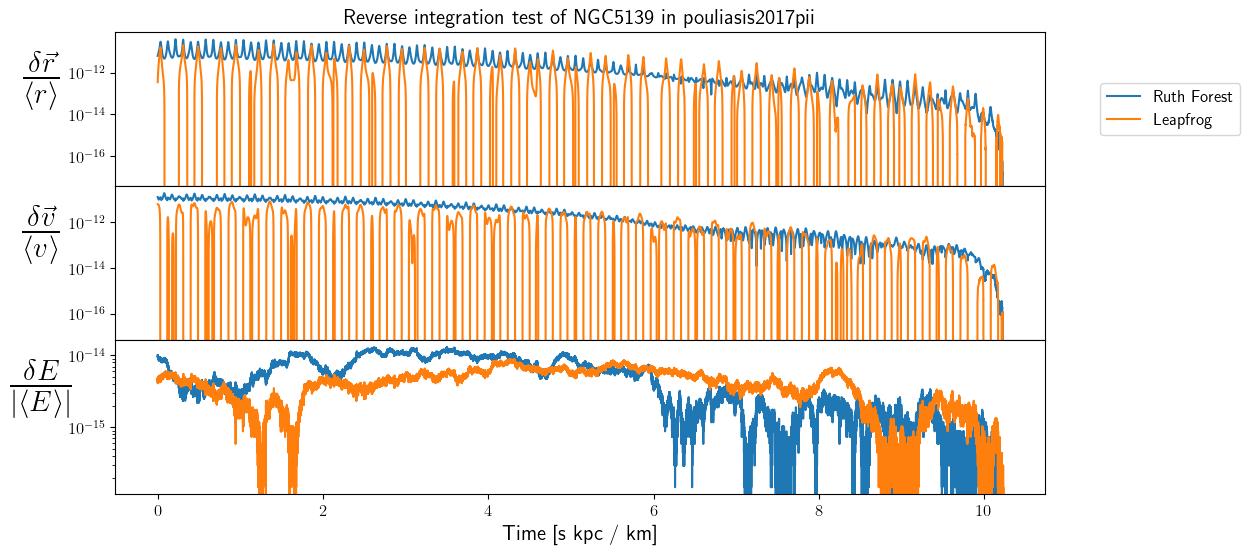

In [16]:
fig,axis=plt.subplots(3,1,figsize=(12,6),sharex=True,gridspec_kw={'hspace':0})
axis[0].plot(time,dR/meanR,label="Ruth Forest")
axis[0].plot(time,dxLF/meanRLF,label="Leapfrog")
axis[0].set_ylabel(rlabel,rotation=0,labelpad=20,fontsize=30)
axis[0].set_yscale("log")
axis[1].plot(time,dV/meanV)
axis[1].plot(time,dvxLF/meanVLF)
axis[1].set_ylabel(vlabel,rotation=0,labelpad=20,fontsize=30)
axis[1].set_yscale("log")

axis[2].plot(time,np.abs(dE/meanE))
axis[2].plot(time,np.abs(dELF/meanELF))
axis[2].set_ylabel(Elabel,rotation=0,labelpad=20,fontsize=30)
axis[2].set_yscale("log")


axis[0].legend(loc='center left', bbox_to_anchor=(1.05, 0.5))

axis[2].set_xlabel("Time [s kpc / km]")

axis[0].set_title("Reverse integration test of {:s} in {:s}".format(targetGC,'pouliasis2017pii'))

In [17]:
tstrippy.integrator.setintegrationparameters(*integrationparameters)
tstrippy.integrator.setstaticgalaxy(*staticgalaxy)
tstrippy.integrator.setinitialkinematics(*initialkinematics)
xtRF,ytRF,ztRF,vxtRF,vytRF,vztRF=tstrippy.integrator.ruthforestintime(NSTEPS,1)
tstrippy.integrator.deallocate()

# now do the reverse
initialkinematics=[xtLF[0,-1],ytLF[0,-1],ztLF[0,-1],-vxtLF[0,-1],-vytLF[0,-1],-vztLF[0,-1]]
tstrippy.integrator.setintegrationparameters(*integrationparameters)
tstrippy.integrator.setstaticgalaxy(*staticgalaxy)
tstrippy.integrator.setinitialkinematics(*initialkinematics)
xtRFr,ytRFr,ztRFr,vxtRFr,vytRFr,vztRFr=tstrippy.integrator.ruthforestintime(NSTEPS,1)
tstrippy.integrator.deallocate()

In [18]:
dxRF,dyRF,dzRF=xtRF[0]-xtRFr[0,::-1],ytRF[0]-ytRFr[0,::-1],ztRF[0]-ztRFr[0,::-1]
dvxRF,dvyRF,dvzRF=vxtRF[0]+vxtRFr[0,::-1],vytRF[0]+vytRFr[0,::-1],vztRF[0]+vztRFr[0,::-1]
meanRRF=np.sqrt((xtRF[0]+xtRFr[0,::-1])**2+(ytRF[0]+ytRFr[0,::-1])**2+(ztRF[0]+ztRFr[0,::-1])**2)/2
meanVRF=np.sqrt((vxtRF[0]-vxtRFr[0,::-1])**2+(vytRF[0]-vytRFr[0,::-1])**2+(vztRF[0]-vztRFr[0,::-1])**2)/2

TRF =( vxtRF[0]**2 + vytRF[0]**2 + vztRF[0]**2)/2
_,_,_,phiRF = tstrippy.potentials.pouliasis2017pii(MWparams, xtRF[0], ytRF[0], ztRF[0])
ERF = TRF + phiRF
TRFR = (vxtRFr[0]**2 + vytRFr[0]**2 + vztRFr[0]**2)/2
_,_,_,phiRFR = tstrippy.potentials.pouliasis2017pii(MWparams, xtRFr[0], ytRFr[0], ztRFr[0])
ERFR = TRFR + phiRFR
dERF=np.sqrt((ERF-ERFR[::-1])**2)
meanERF = (ERF+ERFR[::-1])/2

/tmp/ipykernel_529393/1020420682.py:9: RuntimeWarning: divide by zero encountered in true_divide
  axis[1].plot(time,dvxRF/meanVRF)


Text(0.5, 1.0, 'Reverse integration test of NGC5139 in pouliasis2017pii')

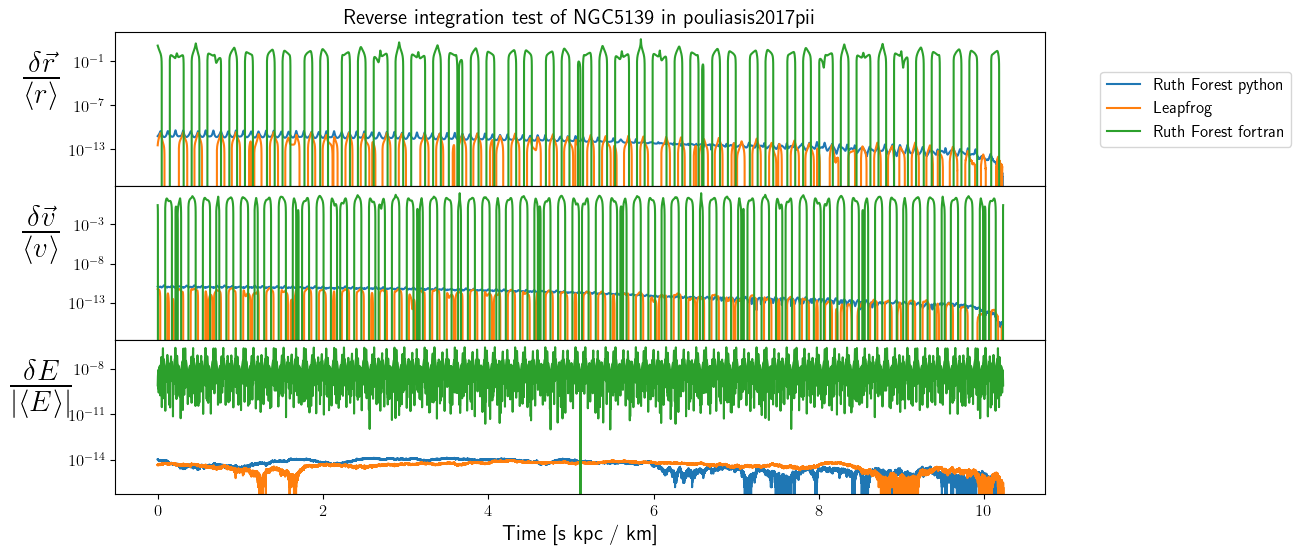

In [19]:
fig,axis=plt.subplots(3,1,figsize=(12,6),sharex=True,gridspec_kw={'hspace':0})
axis[0].plot(time,dR/meanR,label="Ruth Forest python")
axis[0].plot(time,dxLF/meanRLF,label="Leapfrog")
axis[0].plot(time,dxRF/meanRRF,label="Ruth Forest fortran")
axis[0].set_ylabel(rlabel,rotation=0,labelpad=20,fontsize=30)
axis[0].set_yscale("log")
axis[1].plot(time,dV/meanV)
axis[1].plot(time,dvxLF/meanVLF)
axis[1].plot(time,dvxRF/meanVRF)
axis[1].set_ylabel(vlabel,rotation=0,labelpad=20,fontsize=30)
axis[1].set_yscale("log")

axis[2].plot(time,np.abs(dE/meanE))
axis[2].plot(time,np.abs(dELF/meanELF))
axis[2].plot(time,np.abs(dERF/meanERF))
axis[2].set_ylabel(Elabel,rotation=0,labelpad=20,fontsize=30)
axis[2].set_yscale("log")


axis[0].legend(loc='center left', bbox_to_anchor=(1.05, 0.5))

axis[2].set_xlabel("Time [s kpc / km]")

axis[0].set_title("Reverse integration test of {:s} in {:s}".format(targetGC,'pouliasis2017pii'))

In [20]:
print("c1", c1)
print("c2", c2)
print("c3", c3)
print("c4", c4)
print("x", x)

c1 0.6710767839206657
c2 -0.1710767839206657
c3 -0.1710767839206657
c4 0.6710767839206657
x 0.1710767839206657


In [21]:
tstrippy.integrator.printruthcoefficients()

 c1 =   0.67107678392066572     
 c2 =  -0.17107678392066569     
 c3 =  -0.17107678392066569     
 c4 =   0.67107678392066572     
 d1 =    1.3421535678413314     
 d2 =   -1.6843071356826629     
 d3 =    1.3421535678413314     
 d4 =    0.0000000000000000     
 c1+c2+c3+c4 =    1.0000000000000000     
 d1+d2+d3+d4 =    1.0000000000000000     
 w =   0.17107678392066569     


In [22]:
0.17107677459716797-x

-9.323497723867646e-09